# Part 1: model definition

In [1]:
import pandas as pd
import requests
from pathlib import Path
from Bio import SeqIO
from Bio.Blast import NCBIXML
from Bio import AlignIO
from Bio import SearchIO
from Bio.SearchIO.HmmerIO import hmmer3_text
import scipy.stats
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

We start from the output of a BLAST search, using as seed sequence the domain sequence, against uniref50.

In [103]:
#Parse blast output
input_file = Path('Data/1_uniref_blast_hits.xml')

with open(input_file) as f:
  blast_records = NCBIXML.parse(f)
  data = []

  # Iterate PSIBLAST rounds (here just one since it is a simple BLAST)
  for blast_record in blast_records:
      query_id = blast_record.query

      # Iterate alignments
      for i, alignment in enumerate(blast_record.alignments):
          subject_id = alignment.title

          # Iterate pairwise alignments
          for hsp in alignment.hsps:
              data.append((query_id,
                              subject_id,
                              blast_record.query_length,
                              hsp.query,
                              hsp.match,
                              hsp.sbjct,
                              hsp.query_start,
                              hsp.query_end,
                              hsp.sbjct_start,
                              hsp.sbjct_end,
                              hsp.identities,
                              hsp.positives,
                              hsp.gaps,
                              hsp.expect,
                              hsp.score))

              # Skip duplicated subjects
              break

df = pd.DataFrame(data, columns=["query_id", "subject_id", "query_len",
                                  "query_seq", "match_seq", "subject_seq",
                                "query_start", "query_end", "subject_start", "subject_end",
                                "identity", "positive", "gaps", "eval", "bit_score"])
df.iloc[999]

query_id                                                EMBOSS_001
subject_id       UR50:UniRef50_A0A4W5JGG9 Integrin beta n=2 Tax...
query_len                                                      247
query_seq        PVDLYYLMDLSYSMKDDLERVRQLGHALLVRLQEVTHSVRIGFGSF...
match_seq        P+DLY LMD S SMKDDL+ ++++G  L   + +++    IGFG F...
subject_seq      PLDLYILMDFSNSMKDDLDNLKRMGAELAELVGKLSDDYTIGFGKF...
query_start                                                      5
query_end                                                       65
subject_start                                                  132
subject_end                                                    192
identity                                                        28
positive                                                        38
gaps                                                             0
eval                                                      0.000002
bit_score                                                    1

In [104]:
# Get Uniref50 accessions
out_file = 'Data/1_uniref_accessions.list'

with open(out_file, 'w') as fout:
  accessions = list(set([acc.split()[0].split(":")[1] for acc in df['subject_id']]))
  fout.write('\n'.join(accessions) + "\n")

- Accessions were used to retrieve Uniref50 sequences
- We then aligned them with ClustalOmega, and edited the alignment in Jalview by deleting rows with redundancy >= 95%, and deleting columns to the left and right of the most sonserved regions, going from around 7000 columns to around 250.
- We then generated the PSSM and HMM from the edited alignment, and used them to retrieve hits with PSI-Blast and HMMSEARCH against SwissProt

## Evaluate raw alignment

In [105]:
# let's look at entropy of the raw alignment
raw_seqs = []  # [[...], ...]
with open("Data/1_uniref_clustal_raw.fasta") as f:
    for record in AlignIO.read(f, "fasta"):
        raw_seqs.append(list(record.seq))
raw_seqs = np.array(raw_seqs, dtype="str")


In [106]:
aa = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
raw_data = []
for i, column in enumerate(raw_seqs.T):

    # count AA in column
    count = Counter(column)
    count.pop('-')
    count_sorted = sorted(count.items(), key=lambda x:x[1], reverse=True)

    # count non gap AA
    non_gap = np.count_nonzero(column != "-")

    occupancy = non_gap / column.size

    # AA probability in column (gap excluded)
    # probabilities = [count.get(k, 0.0) / column.size for k in aa]
    probabilities = [count.get(k, 0.0) / non_gap for k in aa]

    # Zero entropy = complete conservation
    entropy = scipy.stats.entropy(probabilities, base=20)

    raw_data.append([i, occupancy, entropy, count_sorted])

raw_df = pd.DataFrame(raw_data, columns=['pos', 'occupancy', 'entropy', 'counts'])


<Axes: >

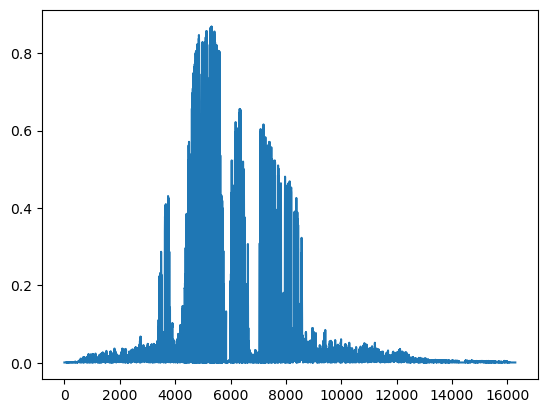

In [113]:
# Occupancy
raw_df['occupancy'].plot()

In [111]:
raw_entropy=raw_df['entropy'].tolist()
smoothed_entropy=[sum(raw_entropy[i:i+50])/50 for i in range(len(raw_entropy)-50)]

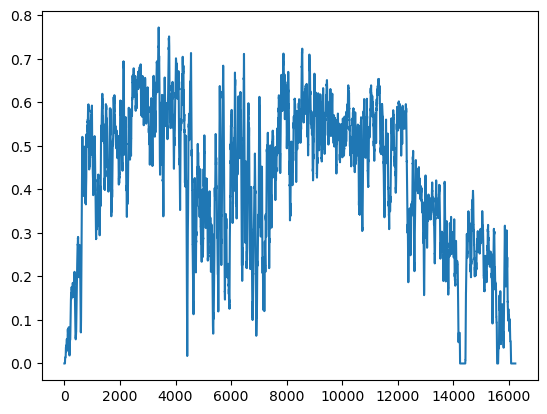

In [112]:
plt.plot(smoothed_entropy)

From these two plots, we can see that the most informative region is around 4000-6000 positions (high occupancy, lower entropy).
We look for a stretch of around 200-300 conserved positions in this regions, and trim to the left and right of it.

In [114]:
edited_seqs=[]
with open("Data/1_uniref_clustal_edited.fasta") as f:
    for record in AlignIO.read(f, "fasta"):
        edited_seqs.append(list(record.seq))
edited_seqs = np.array(edited_seqs, dtype="str")

In [115]:
edited_data = []
for i, column in enumerate(edited_seqs.T):

    # count AA in column
    count = Counter(column)
    try:
        count.pop('-')
    except:
        pass
    count_sorted = sorted(count.items(), key=lambda x:x[1], reverse=True)

    # count non gap AA
    non_gap = np.count_nonzero(column != "-")

    occupancy = non_gap / column.size

    # AA probability in column (gap excluded)
    # probabilities = [count.get(k, 0.0) / column.size for k in aa]
    probabilities = [count.get(k, 0.0) / non_gap for k in aa]

    # Zero entropy = complete conservation
    entropy = scipy.stats.entropy(probabilities, base=20)

    edited_data.append([i, occupancy, entropy, count_sorted])

edited_df = pd.DataFrame(edited_data, columns=['pos', 'occupancy', 'entropy', 'counts'])

<Axes: >

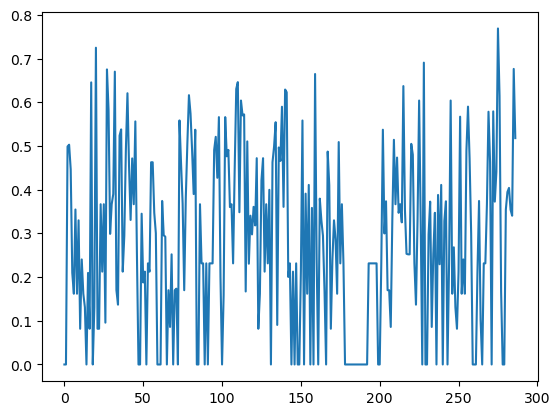

In [116]:
edited_df['entropy'].plot()

# Part 2: model evaluation

In [13]:
import requests
import json

## Collecting ground truth

In [44]:
# We use the interpro API to collect data on all swissprot entries with the assigned Pfam domain
accessions=[]
names=[]
length=[]
taxon=[]
start=[]
end=[]
URL="https://www.ebi.ac.uk:443/interpro/api/protein/reviewed/entry/pfam/PF00362/"
headers={'Content-Type':'application/json'}
r=requests.get(URL,headers=headers)
for node in r.json()['results']:
        metadata=node['metadata']    
        entry=node['entries'][0]
        accessions.append(metadata['accession'])
        names.append(metadata['name'])
        length.append(metadata['length'])
        taxon.append(metadata['source_organism']['taxId'])
        start.append(entry['entry_protein_locations'][0]['fragments'][0]['start'])
        end.append(entry['entry_protein_locations'][0]['fragments'][0]['end'])
while r.json()['next']:
    URL=r.json()['next']
    r=requests.get(URL,headers=headers)
    for node in r.json()['results']:
        metadata=node['metadata']    
        entry=node['entries'][0]
        accessions.append(metadata['accession'])
        names.append(metadata['name'])
        length.append(metadata['length'])
        taxon.append(metadata['source_organism']['taxId'])
        start.append(entry['entry_protein_locations'][0]['fragments'][0]['start'])
        end.append(entry['entry_protein_locations'][0]['fragments'][0]['end'])

In [45]:
d={'accession':accessions,'name':names,'length':length,'taxon':taxon,'start':start,'end':end}
ground_truth=pd.DataFrame(data=d)

In [48]:
ground_truth.head()

,accession,name,length,taxon,start,end
0,A2A863,Integrin beta-4,1818,10090,128,370
1,A5Z1X6,Integrin beta-1,798,9837,138,382
2,B0FYY4,Integrin beta-1,798,9940,138,382
3,O54890,Integrin beta-3,787,10090,133,380
4,O70309,Integrin beta-5,798,10090,134,382


In [26]:
swissprot_IDs=pd.read_table('Data/swissprot_IDs.tsv',header=0)['Entry'].tolist()

## Create confusion matrices

### Parse PSI-BLAST results

In [126]:
psiblast_hits=pd.read_csv('Data/2_uniref_pssm_hits.csv').iloc[:-1]
psiblast_hits.tail()

,Description(Sequences with E-value BETTER than threshold),Scientific Name,Max Score,Total Score,Query Cover,E value,Per. ident,Acc. Len,Accession
42,RecName: Full=Integrin beta-4; AltName: Full=G...,Rattus norvegicus,204,204,97%,1e-59,43.68,1807,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
43,RecName: Full=Integrin beta-4; AltName: CD_ant...,Mus musculus,203,203,97%,1e-59,43.68,1818,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
44,RecName: Full=Integrin beta-2-like protein; Al...,Mus musculus,143,143,99%,1e-38,36.51,738,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
45,RecName: Full=Integrin beta-2 [Xenopus laevis],Xenopus laevis,91.8,91.8,41%,2e-23,50.00,77,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
46,RecName: Full=Alpha-protein kinase vwkA; AltNa...,Dictyostelium discoideum,45.2,45.2,83%,1e-04,22.16,625,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."


In [119]:
pssm_accessions=[]
pssm_positions=[]
with open('Data/2_uniref_pssm_aligns.fasta') as handle:
    for record in SeqIO.parse(handle,'fasta'):
        res=record.id.split(':')
        pssm_accessions.append(res[0].split('.')[0])
        pssm_positions.append(res[1])

In [120]:
pssm_start=[]
pssm_end=[]
for interval in pssm_positions:
    start,end=interval.split('-')
    pssm_start.append(int(start))
    pssm_end.append(int(end))

In [127]:
pssm_evalue=psiblast_hits['E value'].tolist()
pssm_cover=psiblast_hits['Query Cover'].tolist()
pssm_identity=psiblast_hits['Per. ident'].tolist()
pssm_length=psiblast_hits['Acc. Len'].tolist()

In [128]:
pssm_data={'accession':pssm_accessions,'pred_start':pssm_start,'pred_end':pssm_end,'evalue':pssm_evalue,
           'cover':pssm_cover,'identity':pssm_identity,'length':pssm_length}

In [129]:
uniref_pssm_parsed_hits=pd.DataFrame(data=pssm_data)

In [130]:
uniref_pssm_parsed_hits.to_csv('Data/2_uniref_pssm_parsed_hits.csv')

### Parse hmmsearch results

In [166]:
# Dictionary with evalues
hmm_evalues={}
with open('Data/uniref_hmm_hittbl.txt') as handle:
    for result in SearchIO.parse(handle,'hmmer3-tab'):
        for hit in result.hits:
            hmm_accessions.append(hit.id.split('|')[1])
            hmm_evalues[hit.id.split('|')[1]]=hit.evalue

In [170]:
hmm_evalues

{'Q6AYF4': 1.9e-81,
 'Q9Z0T9': 2e-81,
 'P18564': 3.5e-81,
 'P80747': 3.9e-81,
 'O70309': 4.9e-81,
 'P05106': 5.5e-81,
 'P18563': 5.8e-81,
 'P18084': 8.4e-81,
 'Q1RPR6': 9.2e-81,
 'Q863C4': 1.4e-80,
 'Q8SQB8': 1.4e-80,
 'O54890': 1.1e-79,
 'P07228': 1.1e-79,
 'Q8R2H2': 1.3e-78,
 'P05556': 4.4e-78,
 'P09055': 6e-78,
 'P49134': 6.1e-78,
 'B0FYY4': 8e-78,
 'P53712': 1.1e-77,
 'P53713': 1.4e-77,
 'A5Z1X6': 1.4e-77,
 'P12606': 1.9e-77,
 'Q9GLP0': 2.8e-77,
 'P12607': 9.5e-77,
 'P26010': 5e-76,
 'Q5RCA9': 7.8e-76,
 'P26011': 2.4e-75,
 'Q5VI41': 2.5e-74,
 'P11835': 2.5e-74,
 'Q6ECI6': 3.1e-74,
 'Q2VJ42': 3.1e-74,
 'P05107': 7.9e-74,
 'P53714': 1e-73,
 'P32592': 1.2e-73,
 'P11584': 4.3e-73,
 'Q07441': 1.5e-71,
 'Q27874': 4.5e-68,
 'Q0VBD0': 2.4e-63,
 'P26012': 4e-63,
 'P26013': 9e-63,
 'Q27591': 1.8e-62,
 'A2A863': 2.4e-59,
 'Q64632': 3.3e-59,
 'P16144': 7.5e-59,
 'Q3UV74': 2e-34,
 'Q09062': 4.3e-19,
 'Q6B9X6': 0.02,
 'Q8C6K9': 0.059,
 'A6NMZ7': 0.28,
 'O00339': 0.3,
 'Q14587': 0.31,
 'P17032': 

In [171]:
# Create lists of hits' characteristics
hmm_taxon=[]
hmm_accession=[]
hmm_start=[]
hmm_end=[]
hmm_values=[]
with open('Data/uniref_hmm_aligns.txt') as handle:
    records=SeqIO.parse(handle,'stockholm')
    for record in records:
        taxon=record.description.split('=')[2].split(' ')[0]
        rec_id=record.id.split('|')
        accession=rec_id[1]
        start,end=rec_id[2].split('/')[1].split('-')
        if hmm_evalues[accession]<0.01: #e-value threshold
            hmm_taxon.append(taxon)
            hmm_accession.append(accession)
            hmm_start.append(int(start))
            hmm_end.append(int(end))
            hmm_values.append(hmm_evalues[accession])       

In [172]:
# We're missing length
hmm_length=[]
URL='https://www.ebi.ac.uk/proteins/api'
headers={'Accept':'text/x-fasta'}
for accession in hmm_accession:
    r=requests.get(URL+'/proteins/'+accession,headers=headers)
    seq=r.text.split('\n')[1:]
    hmm_length.append(sum([len(piece) for piece in seq]))

In [173]:
hmm_data={'accession':hmm_accession,'pred_start':hmm_start,'pred_end':hmm_end,'taxon':hmm_taxon,'evalue':hmm_values
    ,'length':hmm_length}

In [174]:
uniref_hmm_parsed_hits=pd.DataFrame(data=hmm_data)

In [175]:
uniref_hmm_parsed_hits

,accession,pred_start,pred_end,taxon,evalue,length
0,Q6AYF4,129,317,10116,1.900000e-81,787
1,Q9Z0T9,129,317,10090,2.000000e-81,787
2,P18564,129,317,9606,3.500000e-81,788
3,P80747,134,323,9913,3.900000e-81,800
4,O70309,134,323,10090,4.900000e-81,798
5,P05106,134,322,9606,5.500000e-81,788
6,P18563,129,317,10141,5.800000e-81,788
7,P18084,134,323,9606,8.400000e-81,799
8,Q1RPR6,129,317,9823,9.200000e-81,788
9,Q863C4,129,317,9940,1.400000e-80,787


In [176]:
uniref_hmm_parsed_hits.to_csv('Data/2_uniref_hmm_parsed_hits.csv')

### Protein confusion matrix

In [4]:
ground_truth=pd.read_csv('Data/2_ground_truth.csv')
uniref_pssm_parsed_hits=pd.read_csv('Data/2_uniref_pssm_parsed_hits.csv')
uniref_hmm_parsed_hits=pd.read_csv('Data/2_uniref_hmm_parsed_hits.csv')
swissprot_IDs=pd.read_table('Data/swissprot_IDs.tsv',header=0)['Entry'].tolist()

#### PSSM

In [185]:
uniref_pssm_parsed_hits.iloc[-1]

Unnamed: 0        46
accession     Q6B9X6
pred_start       121
pred_end         254
evalue        0.0001
cover            83%
identity       22.16
length           625
Name: 46, dtype: object

In [82]:
predicted_accessions=uniref_pssm_parsed_hits['accession'].tolist()
true_accessions=ground_truth['accession'].tolist()

In [30]:
truth=[int(ID in true_accessions) for ID in swissprot_IDs]
pred=[int(ID in predicted_accessions) for ID in swissprot_IDs]
conf_matrix_pssm=confusion_matrix(truth,pred)

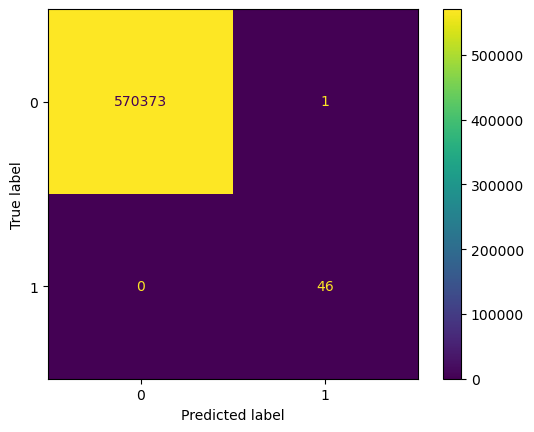

In [32]:
disp=ConfusionMatrixDisplay(conf_matrix_pssm)
disp.plot()

#### HMM

In [5]:
predicted_accessions=uniref_hmm_parsed_hits['accession'].tolist()
true_accessions=ground_truth['accession'].tolist()

In [6]:
predicted_accessions[-1]

'Q09062'

In [7]:
truth=[int(ID in true_accessions) for ID in swissprot_IDs]
pred=[int(ID in predicted_accessions) for ID in swissprot_IDs]
conf_matrix_hmm=confusion_matrix(truth,pred)

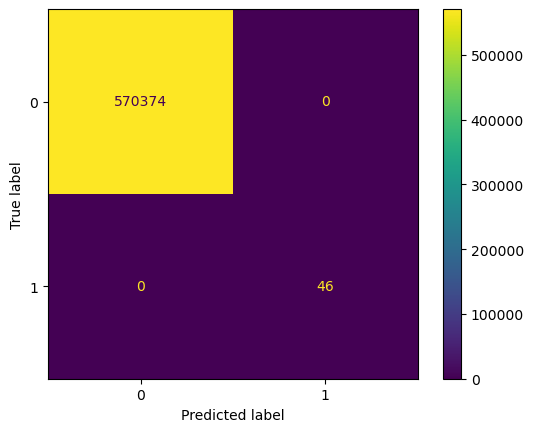

In [8]:
disp=ConfusionMatrixDisplay(conf_matrix_hmm)
disp.plot()

#### Discussion
In both models, we have a single false positive, corresponding to the accession Q6B9X6.
To choose the better model, we compare them at the residue level.

### Residue level results

#### PSSM

In [132]:
merged_data=ground_truth.merge(uniref_pssm_parsed_hits,on='accession',how='inner')

In [133]:
tp=0
fp=0
fn=0
tn=0
for index,row in merged_data.iterrows():
    start=row['start']
    end=row['end']
    pred_start=row['pred_start']
    pred_end=row['pred_end']
    length=row['length_x']
    for i in range(length):
        if start <= i <= end:
            if pred_start <= i <= pred_end:
                tp +=1
            else:
                fn += 1
        else:
            if pred_start <= i <= pred_end:
                fp += 1
            else:
                tn += 1
res_pssm_matrix=np.array([[tn,fp],[fn,tp]])

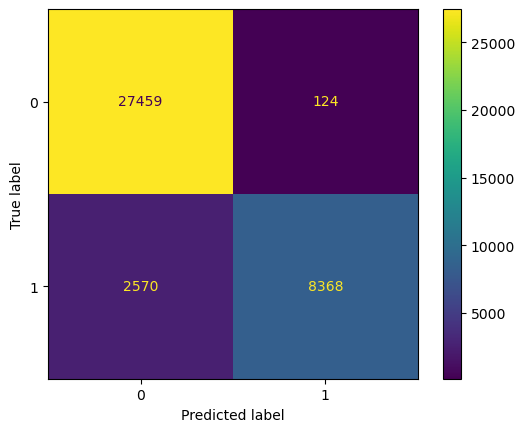

In [134]:
# Display confusion matrix
ConfusionMatrixDisplay(res_pssm_matrix).plot()

In [135]:
# Compute statistics
print('Precision:{}'.format(tp/(tp+fp)))
print('Recall:{}'.format(tp/(tp+fn)))
print('F-score:{}'.format(2*tp/(2*tp+fp+fn)))
print('Balanced accuracy:{}'.format(((tp/(tp+fn)+(tn/(tn+fp)))/2)))

Precision:0.9853980216674517
Recall:0.7650393124885719
F-score:0.8613484302624806
Balanced accuracy:0.8802718949420345


#### HMM

In [181]:
merged_data=ground_truth.merge(uniref_hmm_parsed_hits,on='accession',how='inner')

In [182]:
tp=0
fp=0
fn=0
tn=0
for index,row in merged_data.iterrows():
    start=row['start']
    end=row['end']
    pred_start=row['pred_start']
    pred_end=row['pred_end']
    length=row['length_x']
    for i in range(length):
        if start <= i <= end:
            if pred_start <= i <= pred_end:
                tp +=1
            else:
                fn += 1
        else:
            if pred_start <= i <= pred_end:
                fp += 1
            else:
                tn += 1
res_hmm_matrix=np.array([[tn,fp],[fn,tp]])

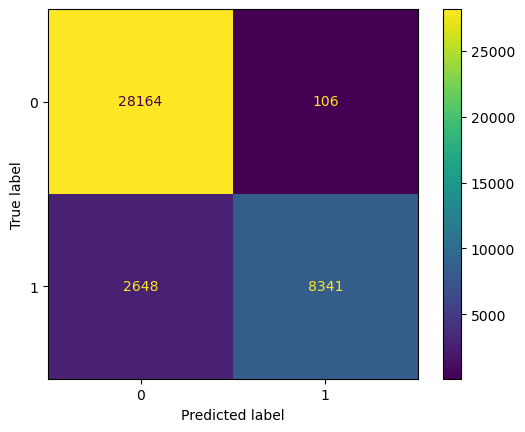

In [183]:
ConfusionMatrixDisplay(res_hmm_matrix).plot()

In [184]:
# Compute statistics
print('Precision:{}'.format(tp/(tp+fp)))
print('Recall:{}'.format(tp/(tp+fn)))
print('F-score:{}'.format(2*tp/(2*tp+fp+fn)))
print('Balanced accuracy:{}'.format(((tp/(tp+fn)+(tn/(tn+fp)))/2)))

Precision:0.9874511660944714
Recall:0.759031759031759
F-score:0.8583041778143651
Balanced accuracy:0.877641100598299


#### Discussion
The models perform very similarly, but the HMM manages to avoid the single false positive the PSSM finds.
For the next parts we will use the HMM hits.

# Part 3: taxonomy

In [3]:
hits=pd.read_csv('Data/2_uniref_hmm_parsed_hits.csv')

In [8]:
hits.head()

,Unnamed: 0,accession,pred_start,pred_end,taxon,evalue,length
0,0,Q6AYF4,129,317,10116,1.900000e-81,787
1,1,Q9Z0T9,129,317,10090,2.000000e-81,787
2,2,P18564,129,317,9606,3.500000e-81,788
3,3,P80747,134,323,9913,3.900000e-81,800
4,4,O70309,134,323,10090,4.900000e-81,798


In [11]:
taxa = hits['taxon'].apply(str).tolist()


In [5]:
URL = "https://www.ebi.ac.uk/proteins/api/taxonomy"   
# Dictionary with lineage of each entry
lineages={}
headers={'Accept':'application/json'}
for index,row in hits.iterrows():
    new_entry=[]
    accession=row['accession']
    taxon=row['taxon']
    Req_url='{}/lineage/{}'.format(URL,taxon)
    r=requests.get(Req_url,headers=headers).json()
    for node in r['taxonomies']:
        new_entry.append((node['rank'],node['scientificName'],node['taxonomyId']))
    lineages[accession]=new_entry[::-1]
            

In [82]:
lineages

{'Q6AYF4': [('no rank', 'root', 1),
  ('no rank', 'cellular organisms', 131567),
  ('superkingdom', 'Eukaryota', 2759),
  ('no rank', 'Opisthokonta', 33154),
  ('kingdom', 'Metazoa', 33208),
  ('no rank', 'Eumetazoa', 6072),
  ('no rank', 'Bilateria', 33213),
  ('no rank', 'Deuterostomia', 33511),
  ('phylum', 'Chordata', 7711),
  ('subphylum', 'Craniata', 89593),
  ('no rank', 'Vertebrata', 7742),
  ('no rank', 'Gnathostomata', 7776),
  ('no rank', 'Teleostomi', 117570),
  ('no rank', 'Euteleostomi', 117571),
  ('superclass', 'Sarcopterygii', 8287),
  ('no rank', 'Dipnotetrapodomorpha', 1338369),
  ('no rank', 'Tetrapoda', 32523),
  ('no rank', 'Amniota', 32524),
  ('class', 'Mammalia', 40674),
  ('no rank', 'Theria', 32525),
  ('no rank', 'Eutheria', 9347),
  ('no rank', 'Boreoeutheria', 1437010),
  ('superorder', 'Euarchontoglires', 314146),
  ('no rank', 'Glires', 314147),
  ('order', 'Rodentia', 9989),
  ('suborder', 'Myomorpha', 1963758),
  ('no rank', 'Muroidea', 337687),
  ('fa

In [7]:
#Dictionary of abundances
weights={}
for lineage in lineages.values():
    for triplet in lineage:
        taxid=triplet[2]
        if taxid in weights.keys():
            weights[taxid]+=1
        else:
            weights[taxid]=1
weights

{1: 46,
 131567: 46,
 2759: 46,
 33154: 46,
 33208: 46,
 6072: 46,
 33213: 46,
 33511: 43,
 7711: 43,
 89593: 43,
 7742: 43,
 7776: 43,
 117570: 43,
 117571: 43,
 8287: 43,
 1338369: 43,
 32523: 43,
 32524: 40,
 40674: 39,
 32525: 39,
 9347: 39,
 1437010: 39,
 314146: 25,
 314147: 15,
 9989: 14,
 1963758: 13,
 337687: 13,
 10066: 13,
 39107: 13,
 10114: 4,
 10116: 4,
 10088: 9,
 862507: 9,
 10090: 9,
 9443: 10,
 376913: 10,
 314293: 10,
 9526: 10,
 314295: 9,
 9604: 9,
 207598: 8,
 9605: 8,
 9606: 8,
 314145: 14,
 91561: 13,
 9845: 9,
 35500: 9,
 9895: 9,
 27592: 4,
 9903: 4,
 9913: 4,
 33550: 1,
 10139: 1,
 10140: 1,
 10141: 1,
 35497: 3,
 9821: 3,
 9822: 3,
 9823: 3,
 9963: 5,
 9935: 4,
 9940: 3,
 8457: 1,
 32561: 1,
 1329799: 1,
 8492: 1,
 436486: 1,
 436489: 1,
 436491: 1,
 436492: 1,
 8782: 1,
 8825: 1,
 1549675: 1,
 8976: 1,
 9005: 1,
 9072: 1,
 9030: 1,
 9031: 1,
 33554: 1,
 379583: 1,
 9681: 1,
 338152: 1,
 9682: 1,
 9685: 1,
 9834: 1,
 9835: 1,
 9836: 1,
 9837: 1,
 8292: 3,
 4

In [46]:
# Create table with lineage of each entry
# We take the named ranks shared by all entries
shared=[]
for lineage in lineages.values():
    ranks=[item[0] for item in lineage if item[0]!='no rank']
    if shared==[]:
        shared=ranks
    else:
        shared=[rank for rank in ranks if rank in shared]
shared

['superkingdom',
 'kingdom',
 'phylum',
 'class',
 'order',
 'family',
 'genus',
 'species']

In [48]:
shared_lineages=[]
for key,value in lineages.items():
    new_lineage=[key]
    for rank,name in value:
        if rank in shared:
            new_lineage.append(name)
    shared_lineages.append(new_lineage)

In [51]:
lineage_data=pd.DataFrame(shared_lineages,columns=['accession']+shared)

In [52]:
lineage_data.to_csv('Data/3_lineages.csv')

In [8]:
import ete3
from ete3 import NCBITaxa
from ete3 import NodeStyle, TreeStyle,TextFace
ncbi = NCBITaxa()

In [9]:
translator = ncbi.get_taxid_translator(weights.keys())

In [18]:
# Define tree
tree = ncbi.get_topology(taxa)
# Add scientific names
for n in tree.traverse():
    n.add_feature('scientificName',translator[int(n.name)])
# Add abundances
for n in tree.traverse():
    n.add_feature('weight',weights[int(n.name)])
# Add labels to nodes
for n in tree.traverse():
    n.add_face(TextFace(n.scientificName), column=0, position ="branch-right")
    n.add_face(TextFace(n.weight), column=1, position ="branch-right")
# Draw nodes based on weight 
for n in tree.traverse():
    nstyle=NodeStyle()
    nstyle['shape']='circle'
    nstyle['fgcolor']='red'
    n.set_style(nstyle)
    n.img_style['size']=5*n.weight
    print(n.img_style['size'])
ts=TreeStyle()
ts.arc_start = -180 # 0 degrees = 3 o'clock
ts.arc_span = 180
ts.show_leaf_name = False
ts.mode = "r"
tree.show(tree_style=ts)

230
15
215
5
10
200
15
195
5
125
70
75
50
65
5
70
5
45
5
45
5
15
65
5
5
40
25
20
20
45
20
5
15
5


AttributeError: '_TreeScene' object has no attribute 'selector'

In [19]:
tree.render('3_tree_image.png')

{'nodes': [[20.5, 270.654296875, 23.5, 273.654296875, 0, None],
  [110.5, 32.5, 113.5, 35.5, 1, None],
  [210.5, 16.0, 213.5, 19.0, 2, None],
  [210.5, 49.0, 213.5, 52.0, 3, None],
  [110.5, 508.80859375, 113.5, 511.80859375, 4, None],
  [215.5, 440.6171875, 218.5, 443.6171875, 5, None],
  [306.5, 337.234375, 309.5, 340.234375, 6, None],
  [435.5, 203.6875, 438.5, 206.6875, 7, None],
  [582.5, 152.125, 585.5, 155.125, 8, None],
  [655.5, 123.25, 658.5, 126.25, 9, None],
  [750.5, 98.5, 753.5, 101.5, 10, None],
  [839.5, 82.0, 842.5, 85.0, 11, None],
  [839.5, 115.0, 842.5, 118.0, 12, None],
  [750.5, 148.0, 753.5, 151.0, 13, None],
  [655.5, 181.0, 658.5, 184.0, 14, None],
  [582.5, 255.25, 585.5, 258.25, 15, None],
  [683.5, 230.5, 686.5, 233.5, 16, None],
  [779.5, 214.0, 782.5, 217.0, 17, None],
  [779.5, 247.0, 782.5, 250.0, 18, None],
  [683.5, 280.0, 686.5, 283.0, 19, None],
  [435.5, 470.78125, 438.5, 473.78125, 20, None],
  [565.5, 430.5625, 568.5, 433.5625, 21, None],
  [683.5

# Part 4: Gene Ontology

In [1]:
#!pip install cafaeval

     ---------------------------------------- 0.0/51.3 kB ? eta -:--:--
     ---------------------------------------- 51.3/51.3 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/68.9 kB ? eta -:--:--
   ---------------------------------------- 68.9/68.9 kB 3.9 MB/s eta 0:00:00


In [3]:
import gzip
import cafaeval
from cafaeval.evaluation import cafa_eval
from cafaeval.parser import obo_parser, gt_parser
import xml.etree.ElementTree as ET
import re
from requests.adapters import HTTPAdapter, Retry
from tqdm import tqdm

re_next_link = re.compile(r'<(.+)>; rel="next"')
retries = Retry(total=5, backoff_factor=0.25, status_forcelist=[500, 502, 503, 504])
session = requests.Session()
session.mount("https://", HTTPAdapter(max_retries=retries))

def get_next_link(headers):
    if "Link" in headers:
        match = re_next_link.match(headers["Link"])
        if match:
            return match.group(1)

def get_batch(batch_url):
    while batch_url:
        response = session.get(batch_url)
        response.raise_for_status()
        total = response.headers["x-total-results"]
        yield response, total
        batch_url = get_next_link(response.headers)

In [4]:
# Parse ontology
ontologies = obo_parser('Data/go.obo')
namespaces = ['molecular_function', 'biological_process', 'cellular_component']

In [43]:
swissprot_IDs=pd.read_table('Data/swissprot_IDs.tsv',header=0)['Entry'].tolist()
family_IDs=set(pd.read_csv('Data/2_uniref_hmm_parsed_hits.csv')['accession'].tolist())

In [42]:
len(set(family_IDs))

46

In [6]:
URL = "https://rest.uniprot.org"

## Family annotations

In [71]:
# Get GO annotations for our family

new_family_annotations={}
for fam_id in tqdm(family_IDs):
    id_annotations=[]
    r = requests.get("{}/uniprot/{}.xml".format(URL,fam_id))  # Without extension, it will look at the 'Accept' header
    NS = {'uniprot': 'http://uniprot.org/uniprot'}
    root = ET.fromstring(r.text)

    for ele in root.findall("uniprot:entry/uniprot:dbReference", NS):
        if ele.attrib["type"] == "GO":
            id_annotations.append(ele.attrib['id'])
    new_family_annotations[fam_id]=id_annotations

100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:46<00:00,  1.00s/it]


## Swissprot annotations

In [10]:
#GO ids for entire swissprot
swissprot_go=pd.read_csv('Data/swissprot_GO.tsv',sep='\t')

In [25]:
swissprot_go.fillna('',inplace=True)

In [12]:
# Build set of annotations present in our family
family_terms=set()
for annotation_list in family_annotations.values():
    family_terms=family_terms.union(set(annotation_list))

In [84]:
len(family_terms)

390

In [26]:
swissprot_go.iloc[418]

Entry                A0A4Y1WBN6
Reviewed               reviewed
Gene Ontology IDs              
Name: 418, dtype: object

## Enrichment

In [27]:
# Now, build dictionary with, for each GO term that appears in the family, the number of times it appears in the family,and the rest of swissprot
go_freqs={}
for index,row in tqdm(swissprot_go.iterrows()):
    if GO_terms:
        GO_terms=row['Gene Ontology IDs'].split('; ')
        for go in GO_terms:
            if go in family_terms:
                if go not in go_freqs.keys():
                    go_freqs[go]=[0,0]
                if row['Entry'] in family_IDs:
                    go_freqs[go][0] += 1
                else:
                    go_freqs[go][1] += 1

570420it [00:33, 16974.86it/s]


In [48]:
#Create Dataframe
go_data=pd.DataFrame.from_dict(data=go_freqs,orient='index',columns=['family','rest'])

In [50]:
go_data['not_family']=len(family_IDs)-go_data['family']

In [51]:
go_data['not_rest']=len(swissprot_IDs)-len(family_IDs)-go_data['rest']

In [53]:
go_data['family_ratio']=go_data['family']/go_data['not_family']
go_data['rest_ratio']=go_data['rest']/go_data['not_rest']
go_data['fold'] = go_data['family_ratio'] / go_data['rest_ratio']

In [55]:
go_data.loc[go_data['family_ratio']>0.3].sort_values(['fold'], ascending=False).head()

,family,rest,not_family,not_rest,family_ratio,rest_ratio,fold
GO:0007229,46,277,0,570097,inf,0.000486,inf
GO:0008305,33,65,13,570309,2.538462,0.000114,2.227242e+04
GO:0033627,22,96,24,570278,0.916667,0.000168,5.445363e+03
GO:0071404,16,66,30,570308,0.533333,0.000116,4.608549e+03
GO:0034113,11,60,35,570314,0.314286,0.000105,2.987359e+03


In [62]:
#Perform Fisher's exact test, two-tailed
#We use a significance level of p=0.05
from scipy.stats import fisher_exact

In [65]:
pvalues=[]
for index,row in go_data.iterrows():
    test_table=np.array([[row['family'],row['rest']],[row['not_family'],row['not_rest']]])
    res_both=fisher_exact(test_table,)
    pvalues.append(res_both[1])

In [67]:
go_data['p-values']=pvalues

In [77]:
go_data.loc[go_data['family_ratio']>0.3].sort_values(['p-values'], ascending=True).head()

,family,rest,not_family,not_rest,family_ratio,rest_ratio,fold,p-values
GO:0007229,46,277,0,570097,inf,0.000486,inf,1.503644e-151
GO:0008305,33,65,13,570309,2.538462,0.000114,2.227242e+04,1.291198e-116
GO:0005925,38,922,8,569452,4.750000,0.001619,2.933728e+03,4.788946e-98
GO:0005178,33,533,13,569841,2.538462,0.000935,2.713920e+03,3.007991e-89
GO:0033627,22,96,24,570278,0.916667,0.000168,5.445363e+03,8.582342e-70


In [ ]:
# Apparently, the family is enriched in all terms that appear in it

In [82]:
go_data.sort_values('p-values',axis=0)

,family,rest,not_family,not_rest,family_ratio,rest_ratio,fold,p-values
GO:0007229,46,277,0,570097,inf,0.000486,inf,1.503644e-151
GO:0008305,33,65,13,570309,2.538462,0.000114,2.227242e+04,1.291198e-116
GO:0005925,38,922,8,569452,4.750000,0.001619,2.933728e+03,4.788946e-98
GO:0005178,33,533,13,569841,2.538462,0.000935,2.713920e+03,3.007991e-89
GO:0033627,22,96,24,570278,0.916667,0.000168,5.445363e+03,8.582342e-70
...,...,...,...,...,...,...,...,...
GO:0043025,1,1884,45,568490,0.022222,0.003314,6.705473e+00,1.412424e-01
GO:0030425,1,2089,45,568285,0.022222,0.003676,6.045264e+00,1.553717e-01
GO:0006915,1,2279,45,568095,0.022222,0.004012,5.539418e+00,1.682640e-01
GO:0005615,1,8270,45,562104,0.022222,0.014713,1.510423e+00,4.892639e-01


In [86]:
go_names=[]
for index,row in go_data.iterrows():
    for ns in namespaces:
        try:
            go_names.append(ontologies[ns].terms_dict[index]['name'])
        except:
            pass

In [87]:
go_data['name']=go_names

In [97]:
#Adjust for multiple testing
from scipy.stats import false_discovery_control
adj_pvalues=false_discovery_control(go_data['p-values'])

In [99]:
go_data['adj_pvalue']=adj_pvalues

In [103]:
enriched_terms=go_data[go_data['adj_pvalue'] < 0.05] 

In [105]:
enriched_terms_sorted=enriched_terms.sort_values('adj_pvalue',axis=0)

In [106]:
enriched_terms

,family,rest,not_family,not_rest,family_ratio,rest_ratio,fold,p-values,name,adj_pvalue
GO:0005813,3,1894,43,568480,0.069767,0.003332,2.094055e+01,5.009615e-04,centrosome,7.104544e-04
GO:0016020,19,22333,27,548041,0.703704,0.040751,1.726855e+01,2.758773e-15,membrane,2.338960e-14
GO:0046872,41,58721,5,511653,8.200000,0.114767,7.144896e+01,2.694844e-35,metal ion binding,6.568683e-34
GO:0005886,22,67367,24,503007,0.916667,0.133929,6.844445e+00,1.749488e-09,plasma membrane,6.038056e-09
GO:0005737,3,163637,43,406737,0.069767,0.402316,1.734143e-01,4.377325e-04,cytoplasm,6.276312e-04
...,...,...,...,...,...,...,...,...,...,...
GO:0003366,2,2,44,570372,0.045455,0.000004,1.296300e+04,3.816702e-08,cell-matrix adhesion involved in ameboidal cel...,1.026561e-07
GO:0034669,2,2,44,570372,0.045455,0.000004,1.296300e+04,3.816702e-08,integrin alpha4-beta7 complex,1.026561e-07
GO:0001573,2,6,44,570368,0.045455,0.000011,4.320970e+03,1.780761e-07,ganglioside metabolic process,4.037772e-07
GO:0099561,1,0,45,570374,0.022222,0.000000,inf,8.064233e-05,synaptic membrane adhesion to extracellular ma...,1.299608e-04


In [15]:
terms_ontologies={}
for go_id in enriched_terms.index:
    for ns in namespaces:
        try:
            _=ontologies[ns].terms_dict[go_id]
            terms_ontologies[go_id]=ns
        except:
            pass

In [16]:
enriched_terms['ontology']=pd.Series(terms_ontologies)

In [19]:
columns=['name','ontology','family','rest','not_family','not_rest','family_ratio','rest_ratio','fold','p-values','adj_pvalue']

In [25]:
enriched_terms=enriched_terms[columns]
enriched_terms=enriched_terms.sort_values('adj_pvalue',axis=0)

In [27]:
enriched_terms.tail()

,name,ontology,family,rest,not_family,not_rest,family_ratio,rest_ratio,fold,p-values,adj_pvalue
GO:0007156,homophilic cell adhesion via plasma membrane a...,biological_process,1,496,45,569878,0.022222,0.000870,25.532168,0.039305,0.041318
GO:0030018,Z disc,cellular_component,1,517,45,569857,0.022222,0.000907,24.494176,0.040932,0.042913
GO:0007267,cell-cell signaling,biological_process,1,539,45,569835,0.022222,0.000946,23.493506,0.042634,0.044577
GO:0042734,presynaptic membrane,cellular_component,1,566,45,569808,0.022222,0.000993,22.371731,0.044718,0.046631
GO:0007005,mitochondrion organization,biological_process,1,606,45,569768,0.022222,0.001064,20.893583,0.047798,0.049710


In [28]:
enriched_terms.to_csv('Data/4_enriched_terms.csv')

In [ ]:
# We have 375 enriched terms

## Word cloud

In [30]:
from wordcloud import WordCloud,STOPWORDS

In [2]:
enriched_terms=pd.read_csv('Data/4_enriched_terms.csv',index_col='Unnamed: 0')

In [31]:
stopwords = set(STOPWORDS)

In [32]:
words=''
for name in enriched_terms['name']:
    new_words=name.lower()
    words +=new_words+" "
    
wordcloud = WordCloud(width = 1200, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)

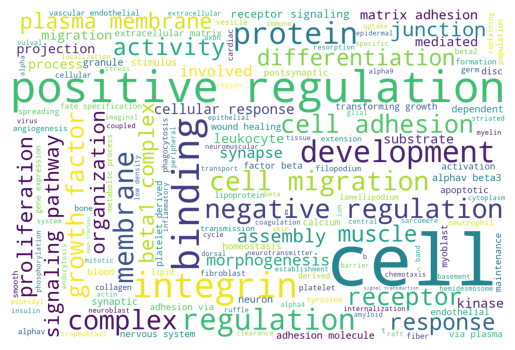

In [41]:
fig,ax=plt.subplots()
ax.set_axis_off()
ax.imshow(wordcloud)

In [42]:
fig.savefig('Figures/4_word_cloud.png')

## Enriched top level terms

In [23]:
enriched_terms=pd.read_csv('Data/4_enriched_terms.csv',index_col='Unnamed: 0')

In [24]:
enriched_terms.head()

,name,ontology,family,rest,not_family,not_rest,family_ratio,rest_ratio,fold,p-values,adj_pvalue
GO:0005813,centrosome,cellular_component,3,1894,43,568480,0.069767,0.003332,20.940547,5.009615e-04,7.104544e-04
GO:0016020,membrane,cellular_component,19,22333,27,548041,0.703704,0.040751,17.268548,2.758773e-15,2.338960e-14
GO:0046872,metal ion binding,molecular_function,41,58721,5,511653,8.200000,0.114767,71.448964,2.694844e-35,6.568683e-34
GO:0005886,plasma membrane,cellular_component,22,67367,24,503007,0.916667,0.133929,6.844445,1.749488e-09,6.038056e-09
GO:0005737,cytoplasm,cellular_component,3,163637,43,406737,0.069767,0.402316,0.173414,4.377325e-04,6.276312e-04


In [8]:
def depth_first_search(matrix, node, visited):

  # Set current node as visited
  visited[node] = 1

  # For every node of the graph
  for j in range(matrix.shape[0]):

    # If some node is adjacent to the current node and it has not already been visited
    if (matrix[node][j] == 1 and (not visited[j])):
        depth_first_search(matrix, j, visited)

In [9]:
enriched_ids=enriched_terms.index.tolist()

In [10]:
#Strategy: we start from each enriched term, and create a set of their children
#We then select the enriched terms that aren't children of other terms
# 1st:dictionary of ontologies
children=[]
for go_id in enriched_ids:
    ns=terms_ontologies[go_id]
    term_index = ontologies[ns].terms_dict[go_id]['index']
    visited = np.zeros(ontologies[ns].dag.shape[0])
    depth_first_search(ontologies[ns].dag.T, term_index, visited)
    for go_index in np.nonzero(visited)[0][1:]:  # Exclude first visited node
        children.append(ontologies[ns].terms_list[go_index]['id'])
children=set(children)
children

{'GO:1902816',
 'GO:0070877',
 'GO:2001232',
 'GO:0071609',
 'GO:0032887',
 'GO:0050731',
 'GO:0007484',
 'GO:0000974',
 'GO:0019037',
 'GO:0099527',
 'GO:1904466',
 'GO:0051496',
 'GO:0042667',
 'GO:0090512',
 'GO:0006898',
 'GO:0097071',
 'GO:0097630',
 'GO:0035551',
 'GO:0080169',
 'GO:0031768',
 'GO:0002722',
 'GO:0035320',
 'GO:0110071',
 'GO:0070149',
 'GO:1901148',
 'GO:1990528',
 'GO:0033596',
 'GO:0061415',
 'GO:1990065',
 'GO:0031502',
 'GO:1990444',
 'GO:0007433',
 'GO:0060534',
 'GO:0035649',
 'GO:0035658',
 'GO:0001113',
 'GO:0097127',
 'GO:0120127',
 'GO:0002789',
 'GO:0061646',
 'GO:0021811',
 'GO:0002246',
 'GO:0048685',
 'GO:0021535',
 'GO:0010666',
 'GO:1903180',
 'GO:0006436',
 'GO:0021797',
 'GO:0072670',
 'GO:0060482',
 'GO:0070565',
 'GO:0021502',
 'GO:0048786',
 'GO:0071263',
 'GO:0032046',
 'GO:0032226',
 'GO:0062141',
 'GO:1904051',
 'GO:0048842',
 'GO:0060510',
 'GO:0043662',
 'GO:0034271',
 'GO:1990383',
 'GO:0098820',
 'GO:0150023',
 'GO:0072295',
 'GO:00003

In [12]:
top_terms=(set(enriched_ids)-children)

In [44]:
top_level=enriched_terms[enriched_terms.index.isin(top_terms)]

In [45]:
top_level

,name,ontology,family,rest,not_family,not_rest,family_ratio,rest_ratio,fold,p-values,adj_pvalue
GO:0007229,integrin-mediated signaling pathway,biological_process,46,277,0,570097,inf,0.000486,inf,1.503644e-151,5.864212e-149
GO:1901388,regulation of transforming growth factor beta ...,biological_process,10,10,36,570364,0.277778,0.000018,1.584344e+04,7.489809e-37,2.246943e-35
GO:0010710,regulation of collagen catabolic process,biological_process,9,3,37,570371,0.243243,0.000005,4.624630e+04,1.375480e-35,3.576247e-34
GO:0007520,myoblast fusion,biological_process,12,94,34,570280,0.352941,0.000165,2.141227e+03,3.439143e-35,7.889798e-34
GO:0001968,fibronectin binding,molecular_function,10,114,36,570260,0.277778,0.000200,1.389522e+03,6.575690e-28,1.115008e-26
...,...,...,...,...,...,...,...,...,...,...,...
GO:0042802,identical protein binding,molecular_function,3,7615,43,562759,0.069767,0.013532,5.155910e+00,2.359779e-02,2.556427e-02
GO:0050766,positive regulation of phagocytosis,biological_process,1,314,45,570060,0.022222,0.000551,4.034395e+01,2.509023e-02,2.710579e-02
GO:0001726,ruffle,cellular_component,1,378,45,569996,0.022222,0.000663,3.350947e+01,3.011213e-02,3.244124e-02
GO:0007608,sensory perception of smell,biological_process,1,420,45,569954,0.022222,0.000737,3.015630e+01,3.339399e-02,3.568125e-02
